In [1]:
import pandas as pd
import numpy as np
import os
from nice_funcs.indicators import CreateRandomPrtf,EWMA,MACD,RSI,NormalizeWindow
from stable_baselines3 import DDPG ,PPO
from ambiente import TradingEnv


    

def GetIndex(*args):
  indicators = [*args]
  index_init = set(indicators[0].index)
  for ind_ in indicators:
    index_init = index_init & set(ind_.index)
  
  idx_date = min(index_init)
  new_index_indicators = []
  for ind_ in indicators:
    ind_['Cash'] = 0 
    new_index_indicators.append(ind_[idx_date:])
  return new_index_indicators
        


# %%
path_diario = './assets/1d/'
ativos = os.listdir(path_diario)

ativosOHLC = {}
for ativo in ativos:
    ativosOHLC[ativo.replace('.xlsx','')] = \
        pd.read_excel(os.path.join(path_diario,ativo),index_col=0)
    

close_prices = {}
for k in ativosOHLC.keys():
  close_prices[k] = ativosOHLC[k].Close


# %%
df_fechamento = pd.DataFrame(close_prices)
macd = df_fechamento.apply(lambda row: MACD(row)[0]).dropna()
rsi = df_fechamento.apply(lambda row: RSI(row)).dropna()
ewma_diff = df_fechamento.apply(lambda row: EWMA(row,20) - EWMA(row,5)).dropna()
normalized_fech = df_fechamento.apply(lambda row: NormalizeWindow(row)).dropna()

# %%
  

# %%
df_fechamento = pd.DataFrame(close_prices).iloc[-360:]
print(df_fechamento)
macd = df_fechamento.apply(lambda row: MACD(row)[0]).dropna()
rsi = df_fechamento.apply(lambda row: RSI(row)).dropna()
ewma_diff = df_fechamento.apply(lambda row: EWMA(row,20) - EWMA(row,5)).dropna()
normalized_fech = df_fechamento.apply(lambda row: NormalizeWindow(row)).dropna()
df_fechamento,normalized_fech,macd,rsi,ewma_diff =  GetIndex(df_fechamento,normalized_fech, macd, rsi, ewma_diff)


# %%
env = TradingEnv(df_fechamento,[normalized_fech,macd,rsi,ewma_diff])

            ADAUSDT  BNBUSDT   BTCUSDT  ETHUSDT  LTCUSDT  XRPUSDT
Date                                                             
2022-08-10   0.5374    328.8  23954.05  1853.57    61.59   0.3814
2022-08-11   0.5303    323.6  23934.39  1880.19    61.84   0.3802
2022-08-12   0.5402    327.9  24403.68  1958.28    62.88   0.3796
2022-08-13   0.5593    324.3  24441.38  1983.55    63.80   0.3780
2022-08-14   0.5695    317.6  24305.24  1935.31    63.14   0.3757
...             ...      ...       ...      ...      ...      ...
2023-07-31   0.3070    241.0  29232.25  1856.14    92.28   0.6976
2023-08-01   0.3103    247.7  29705.99  1873.47    93.94   0.7069
2023-08-02   0.2993    240.7  29186.01  1839.90    87.54   0.6850
2023-08-03   0.2922    241.1  29193.64  1835.81    82.55   0.6630
2023-08-04   0.2937    241.5  29201.83  1835.98    83.13   0.6662

[360 rows x 6 columns]


In [97]:
model = PPO.load('./Training/Saved Models/trading_2.zip') 

In [98]:
stats = {
  'ganho_total':[],
  'total_turnos':[],
  'acoes':[],
  'prtf':[],
  'valor':[]}
for _ in range(1):
  obs,_ = env.reset()
  total_ganho = 0
  done = False
  truncated = False
  termination = (done or truncated)
  acoes = []
  rewards = []
  while not termination:
      action,_ = model.predict(obs,deterministic=True)
      obs,reward, done ,truncated,info = env.step(action)
      total_ganho +=reward
      termination = (done or truncated)
      if sum(action) != 0:
         action = action/sum(action)
      else:
         action = env.softmax_normalization(action)
      acoes.append(action)
      rewards.append(reward)
  stats['ganho_total'].append(total_ganho)
  stats['total_turnos'].append(env.step_)
  stats['prtf'].append(acoes)
  stats['valor'].append(rewards)

**************************************************
Retorno 1456.05
[0.18566786 0.         0.28118104 0.0373534  0.15137789 0.
 0.3444198 ]
[0.18566786 0.         0.28118104 0.0373534  0.15137789 0.
 0.3444198 ]
[0.18544647 0.         0.28145874 0.03698901 0.15213558 0.
 0.34397018]
[0.18544556 0.         0.2814597  0.03698795 0.15213822 0.
 0.34396863]
[0.18543555 0.         0.2814613  0.03698798 0.15214947 0.
 0.34396565]
[0.13118425 0.         0.1534014  0.1176231  0.08504815 0.
 0.51274306]
[0.42218608 0.         0.         0.05378208 0.         0.
 0.5240318 ]
[0.5760783  0.05561431 0.         0.         0.         0.04127628
 0.3270311 ]
[0.39146465 0.22118664 0.         0.         0.         0.19490549
 0.19244325]
[0.4750295  0.11623454 0.         0.         0.         0.09315625
 0.31557968]
[0.39508128 0.         0.         0.05998705 0.         0.
 0.5449317 ]
[0.17964278 0.         0.1266152  0.11185481 0.         0.
 0.58188725]
[0.16488452 0.         0.15508232 0.11957821 

In [100]:
(0.001801/0.032975)*np.sqrt(360)

1.0362872599174986

In [99]:
(pd.Series(stats['valor'][0]).cumsum() +1000).pct_change().mean()

0.001740972342584108

In [101]:
(pd.DataFrame(stats['prtf'][0],columns=df_fechamento.columns)*100).sum(axis=1).describe()

count    333.000000
mean     100.000000
std        0.000003
min       99.999985
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000015
dtype: float64

In [105]:
(pd.DataFrame(stats['prtf'][0],columns=df_fechamento.columns)*100).mean()

ADAUSDT    10.170312
BNBUSDT    18.834146
BTCUSDT    12.849209
ETHUSDT     9.964257
LTCUSDT     6.860868
XRPUSDT    19.301050
Cash       22.020159
dtype: float32

<Axes: >

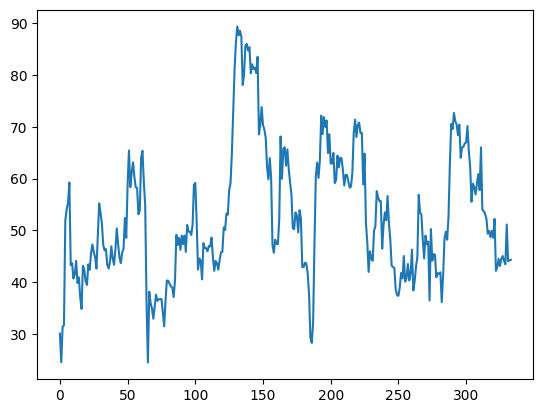

In [51]:
rsi.reset_index()['BTCUSDT'].plot()

In [4]:
returns = df_fechamento.pct_change().iloc[1:].fillna(0)

In [5]:
log_returns = np.log(1+returns)

In [6]:
equal_pesos = [1/len(log_returns.columns)]*len(log_returns.columns)

In [7]:
prtf_returns = (log_returns * equal_pesos).sum(axis=1)

In [39]:
(np.exp(prtf_returns.cumsum()))

Date
2022-09-06    0.949475
2022-09-07    0.986970
2022-09-08    0.991250
2022-09-09    1.041289
2022-09-10    1.058097
                ...   
2023-07-31    1.164755
2023-08-01    1.180595
2023-08-02    1.146926
2023-08-03    1.128134
2023-08-04    1.131194
Length: 333, dtype: float64

In [12]:
pd.Series(stats['ganho_total']).describe()

count      1.000000
mean     456.047333
std             NaN
min      456.047333
25%      456.047333
50%      456.047333
75%      456.047333
max      456.047333
dtype: float64

In [41]:
pd.Series(stats['ganho_total']).mean()

456.04733290251414

In [13]:
1456/1000 -1

0.45599999999999996